<a href="https://colab.research.google.com/github/nishanthjois/Deep-Learning-2/blob/master/ocr_document.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

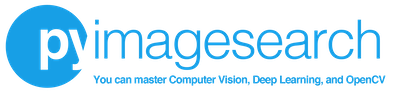

# OCR a document, form, or invoice with Tesseract, OpenCV, and Python
### by [PyImageSearch.com](http://www.pyimagesearch.com)

## Welcome to **[PyImageSearch Plus](http://pyimg.co/plus)** Jupyter Notebooks!

This notebook is associated with the [OCR a document, form, or invoice with Tesseract, OpenCV, and Python](https://www.pyimagesearch.com/2020/09/07/ocr-a-document-form-or-invoice-with-tesseract-opencv-and-python/) blog post published on 2020-09-07.

Only the code for the blog post is here. Most codeblocks have a 1:1 relationship with what you find in the blog post with two exceptions: (1) Python classes are not separate files as they are typically organized with PyImageSearch projects, and (2) Command Line Argument parsing is replaced with an `args` dictionary that you can manipulate as needed.

We recommend that you execute (press ▶️) the code block-by-block, as-is, before adjusting parameters and `args` inputs. Once you've verified that the code is working, you are welcome to hack with it and learn from manipulating inputs, settings, and parameters. For more information on using Jupyter and Colab, please refer to these resources:

*   [Jupyter Notebook User Interface](https://jupyter-notebook.readthedocs.io/en/stable/notebook.html#notebook-user-interface)
*   [Overview of Google Colaboratory Features](https://colab.research.google.com/notebooks/basic_features_overview.ipynb)

As a reminder, these PyImageSearch Plus Jupyter Notebooks are not for sharing; please refer to the **Copyright** directly below and **Code License Agreement** in the last cell of this notebook. 

Happy hacking!

*Adrian*

<hr>

***Copyright:*** *The contents of this Jupyter Notebook, unless otherwise indicated, are Copyright 2020 Adrian Rosebrock, PyimageSearch.com. All rights reserved. Content like this is made possible by the time invested by the authors. If you received this Jupyter Notebook and did not purchase it, please consider making future content possible by joining PyImageSearch Plus at http://pyimg.co/plus/ today.*

### Install the necessary packages

In [1]:
!sudo apt-get install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 34 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 1s (5,398 kB/s)
debconf: unable to initi

### Download the code zip file

In [2]:
!wget https://s3-us-west-2.amazonaws.com/static.pyimagesearch.com/ocr-document/ocr-document.zip
!unzip -qq ocr-document.zip
%cd ocr-document

--2021-05-15 04:37:23--  https://s3-us-west-2.amazonaws.com/static.pyimagesearch.com/ocr-document/ocr-document.zip
Resolving s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)... 52.218.182.184
Connecting to s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)|52.218.182.184|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12267611 (12M) [application/zip]
Saving to: ‘ocr-document.zip’

ocr-document.zip    100%[===================>]  11.70M  10.3MB/s    in 1.1s    

2021-05-15 04:37:24 (10.3 MB/s) - ‘ocr-document.zip’ saved [12267611/12267611]

/content/ocr-document


## Blog Post Code

### Import Packages

In [3]:
# import the necessary packages
from pyimagesearch.alignment import align_images
from matplotlib import pyplot as plt
from collections import namedtuple
import pytesseract
import argparse
import imutils
import cv2

### Function to display images in Jupyter Notebooks and Google Colab

In [4]:
def plt_imshow(title, image):
	# convert the image frame BGR to RGB color space and display it
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	plt.imshow(image)
	plt.title(title)
	plt.grid(False)
	plt.show()

### Implementing our document OCR script with OpenCV and Tesseract

In [5]:
def cleanup_text(text):
	# strip out non-ASCII text so we can draw the text on the image
	# using OpenCV
	return "".join([c if ord(c) < 128 else "" for c in text]).strip()

In [6]:
# construct the argument parser and parse the arguments
#ap = argparse.ArgumentParser()
#ap.add_argument("-i", "--image", required=True,
#	help="path to input image that we'll align to template")
#ap.add_argument("-t", "--template", required=True,
#	help="path to input template image")
#args = vars(ap.parse_args())

# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
	"image": "scans/scan_01.jpg",
	"template": "form_w4.png"
}

In [7]:
# create a named tuple which we can use to create locations of the
# input document which we wish to OCR
OCRLocation = namedtuple("OCRLocation", ["id", "bbox",
	"filter_keywords"])

# define the locations of each area of the document we wish to OCR
OCR_LOCATIONS = [
	OCRLocation("step1_first_name", (265, 237, 751, 106),
		["middle", "initial", "first", "name"]),
	OCRLocation("step1_last_name", (1020, 237, 835, 106),
		["last", "name"]),
	OCRLocation("step1_address", (265, 336, 1588, 106),
		["address"]),
	OCRLocation("step1_city_state_zip", (265, 436, 1588, 106),
		["city", "zip", "town", "state"]),
	OCRLocation("step5_employee_signature", (319, 2516, 1487, 156),
		["employee", "signature", "form", "valid", "unless",
		 	"you", "sign"]),
	OCRLocation("step5_date", (1804, 2516, 504, 156), ["date"]),
	OCRLocation("employee_name_address", (265, 2706, 1224, 180),
		["employer", "name", "address"]),
	OCRLocation("employee_ein", (1831, 2706, 448, 180),
		["employer", "identification", "number", "ein"]),
]

In [8]:
# load the input image and template from disk
print("[INFO] loading images...")
image = cv2.imread(args["image"])
template = cv2.imread(args["template"])

# align the images
print("[INFO] aligning images...")
aligned = align_images(image, template)

[INFO] loading images...
[INFO] aligning images...


In [9]:
# initialize a results list to store the document OCR parsing results
print("[INFO] OCR'ing document...")
parsingResults = []

# loop over the locations of the document we are going to OCR
for loc in OCR_LOCATIONS:
	# extract the OCR ROI from the aligned image
	(x, y, w, h) = loc.bbox
	roi = aligned[y:y + h, x:x + w]

	# OCR the ROI using Tesseract
	rgb = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
	text = pytesseract.image_to_string(rgb)

    # break the text into lines and loop over them
	for line in text.split("\n"):
		# if the line is empty, ignore it
		if len(line) == 0:
			continue

		# convert the line to lowercase and then check to see if the
		# line contains any of the filter keywords (these keywords
		# are part of the *form itself* and should be ignored)
		lower = line.lower()
		count = sum([lower.count(x) for x in loc.filter_keywords])

		# if the count is zero then we know we are *not* examining a
		# text field that is part of the document itself (ex., info,
		# on the field, an example, help text, etc.)
		if count == 0:
			# update our parsing results dictionary with the OCR'd
			# text if the line is *not* empty
			parsingResults.append((loc, line))

[INFO] OCR'ing document...


In [10]:
# initialize a dictionary to store our final OCR results
results = {}

# loop over the results of parsing the document
for (loc, line) in parsingResults:
	# grab any existing OCR result for the current ID of the document
	r = results.get(loc.id, None)

	# if the result is None, initialize it using the text and location
	# namedtuple (converting it to a dictionary as namedtuples are not
	# hashable)
	if r is None:
		results[loc.id] = (line, loc._asdict())

	# otherwise, there exists an OCR result for the current area of the
	# document, so we should append our existing line
	else:
		# unpack the existing OCR result and append the line to the
		# existing text
		(existingText, loc) = r
		text = "{}\n{}".format(existingText, line)

		# update our results dictionary
		results[loc["id"]] = (text, loc)

In [11]:
# loop over the results
for (locID, result) in results.items():
	# unpack the result tuple
	(text, loc) = result

	# display the OCR result to our terminal
	print(loc["id"])
	print("=" * len(loc["id"]))
	print("{}\n\n".format(text))

	# extract the bounding box coordinates of the OCR location and
	# then strip out non-ASCII text so we can draw the text on the
	# output image using OpenCV
	(x, y, w, h) = loc["bbox"]
	clean = cleanup_text(text)

	# draw a bounding box around the text
	cv2.rectangle(aligned, (x, y), (x + w, y + h), (0, 255, 0), 2)

	# loop over all lines in the text
	for (i, line) in enumerate(text.split("\n")):
		# draw the line on the output image
		startY = y + (i * 70) + 40
		cv2.putText(aligned, line, (x, startY),
			cv2.FONT_HERSHEY_SIMPLEX, 1.8, (0, 0, 255), 5)

step1_first_name
Adrian



step1_last_name
Rosebrock



step1_address
PO Box 17598 #17900



step1_city_state_zip
Baltimore, MD 21297-1598



step5_employee_signature
Adrian Rosebrock



step5_date
2020/06/10



employee_name_address
 
PylmageSearch
PO BOX 1234
Philadelphia, PA 19019



employee_ein
 
12-3456789





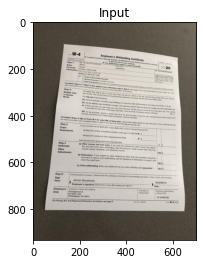

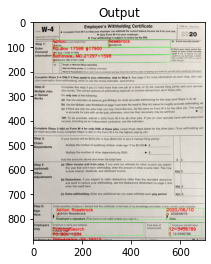

In [12]:
# show the input and output images, resizing it such that they fit
# on our screen
plt_imshow("Input", imutils.resize(image, width=700))
plt_imshow("Output", imutils.resize(aligned, width=700))

For a detailed walkthrough of the concepts and code, be sure to refer to the full tutorial, [*OCR a document, form, or invoice with Tesseract, OpenCV, and Python*](https://www.pyimagesearch.com/2020/09/07/ocr-a-document-form-or-invoice-with-tesseract-opencv-and-python/) published on 2020-09-07.

# Code License Agreement
```
Copyright (c) 2020 PyImageSearch.com

SIMPLE VERSION
Feel free to use this code for your own projects, whether they are
purely educational, for fun, or for profit. THE EXCEPTION BEING if
you are developing a course, book, or other educational product.
Under *NO CIRCUMSTANCE* may you use this code for your own paid
educational or self-promotional ventures without written consent
from Adrian Rosebrock and PyImageSearch.com.

LONGER, FORMAL VERSION
Permission is hereby granted, free of charge, to any person obtaining
a copy of this software and associated documentation files
(the "Software"), to deal in the Software without restriction,
including without limitation the rights to use, copy, modify, merge,
publish, distribute, sublicense, and/or sell copies of the Software,
and to permit persons to whom the Software is furnished to do so,
subject to the following conditions:
The above copyright notice and this permission notice shall be
included in all copies or substantial portions of the Software.
Notwithstanding the foregoing, you may not use, copy, modify, merge,
publish, distribute, sublicense, create a derivative work, and/or
sell copies of the Software in any work that is designed, intended,
or marketed for pedagogical or instructional purposes related to
programming, coding, application development, or information
technology. Permission for such use, copying, modification, and
merger, publication, distribution, sub-licensing, creation of
derivative works, or sale is expressly withheld.
THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND,
EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES
OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND
NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS
BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN
ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
```